In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

# Define paths and directories
data_dir = '/home/sahid/Desktop/Dataset/content/test'
ckpt_path = '/home/sahid/Desktop/ali/lag-llama/sahid/lag-llama.ckpt'

# Load and preprocess data in chunks
data_frames = []
for filename in os.listdir(data_dir):
    for chunk in pd.read_csv(os.path.join(data_dir, filename), sep='\t', chunksize=10000):
        # Process each chunk as needed
        dataset_mean_abs = chunk.abs().mean()
        data_frames.append(pd.DataFrame(dataset_mean_abs.values.reshape(1, -1),
                                        columns=['experiment_1', 'experiment_2', 'experiment_3', 'experiment_4']))

# Concatenate data into a single DataFrame after processing chunks
merged_data = pd.concat(data_frames, ignore_index=True)

# Assuming 'timestamp' is not a column name from data and should be generated
# Set index with a range
merged_data.index = pd.date_range(start='2000-01-01', periods=len(merged_data), freq='D')

# Save merged data to CSV
merged_data.to_csv('merged_Dataset_experiment.csv')
print(merged_data.head())

# Continue with model integration, evaluation, and visualization as previously discussed


# Define train and test datasets
train_start = '2004-02-12 11:02:39'
train_end = '2004-02-13 23:52:39'
test_start = '2004-02-13 23:52:39'

# Ensure data is properly aligned and processed
dataset_train = merged_data.loc[train_start:train_end]
dataset_test = merged_data.loc[test_start:]


            Bearing 1  Bearing 2  Bearing 3  Bearing 4
2000-01-01   0.061636   0.074461   0.079850   0.043428
2000-01-02   0.060954   0.074154   0.077601   0.043864
2000-01-03   0.054737   0.071524   0.071931   0.040119
2000-01-04   0.118732   0.076435   0.078924   0.051461
2000-01-05   0.118869   0.079039   0.079826   0.050557


In [2]:
# Prepare dataset for Lag-Llama
prediction_length = 48
context_length = 32

# Assuming 'Bearing 1' is the target column
# Create ListDataset for training and testing
train_ds = ListDataset(
    [{"start": dataset_train.index[0], "target": dataset_train['Bearing 1'].values}],
    freq="1H"  # Adjust frequency as needed
)

test_ds = ListDataset(
    [{"start": dataset_test.index[0], "target": dataset_test['Bearing 1'].values}],
    freq="1H"  # Adjust frequency as needed
)


# Load the pretrained model checkpoint
ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Create the Lag-Llama estimator
estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

# Create the prediction module and transformations
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

# Perform predictions
forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor)

# Retrieve the forecasts and time series
forecasts = list(forecast_it)
tss = list(ts_it)

# Evaluate the model using Evaluator
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

# Print evaluation metrics
print("Metrics:", agg_metrics)


Running evaluation: 1it [00:00,  9.10it/s]


Metrics: {'MSE': 0.005656977494557698, 'abs_error': 1.5083410739898682, 'abs_target_sum': 4.509113311767578, 'abs_target_mean': 0.09393986066182454, 'seasonal_error': 0.03265711836381392, 'MASE': 0.96223347157318, 'MAPE': 0.19843061765034994, 'sMAPE': 0.25518343846003216, 'MSIS': 22.140595601340777, 'num_masked_target_values': 0.0, 'QuantileLoss[0.1]': 0.5400624461472034, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.2]': 0.8123369798064233, 'Coverage[0.2]': 0.0, 'QuantileLoss[0.3]': 1.0433996342122553, 'Coverage[0.3]': 0.0625, 'QuantileLoss[0.4]': 1.284683169424534, 'Coverage[0.4]': 0.16666666666666666, 'QuantileLoss[0.5]': 1.5083411522209644, 'Coverage[0.5]': 0.4583333333333333, 'QuantileLoss[0.6]': 1.7163150325417518, 'Coverage[0.6]': 0.5833333333333334, 'QuantileLoss[0.7]': 1.8561515994369984, 'Coverage[0.7]': 0.7083333333333334, 'QuantileLoss[0.8]': 1.9750254020094873, 'Coverage[0.8]': 0.75, 'QuantileLoss[0.9]': 1.8769907288253307, 'Coverage[0.9]': 0.7708333333333334, 'RMSE': 0.0752128811

First forecast: gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[0.14841425, 0.16488956, 0.0973527 , ..., 0.08377361, 0.06418896,
        0.03029565],
       [0.13465434, 0.09370826, 0.10569839, ..., 0.0693566 , 0.06067382,
        0.0539453 ],
       [0.12680541, 0.13653076, 0.12239254, ..., 0.09494352, 0.08088376,
        0.02461852],
       ...,
       [0.16159019, 0.1911065 , 0.232716  , ..., 0.10129328, 0.08748131,
        0.14798015],
       [0.13877985, 0.13637662, 0.11212693, ..., 0.04873966, 0.01282815,
        0.05161425],
       [0.10339829, 0.11701174, 0.11129805, ..., 0.02935368, 0.03421814,
        0.04657633]], dtype=float32), start_date=Period('2004-04-12 07:00', 'H'))
First time series:                          0
2004-02-14 00:00  0.080440
2004-02-14 01:00  0.061457
2004-02-14 02:00  0.058138
2004-02-14 03:00  0.059906
2004-02-14 04:00  0.060343
...                    ...
2004-04-14 02:00  0.070678
2004-04-14 03:00  0.070123
2004-04-14 04:

<Figure size 1000x700 with 0 Axes>

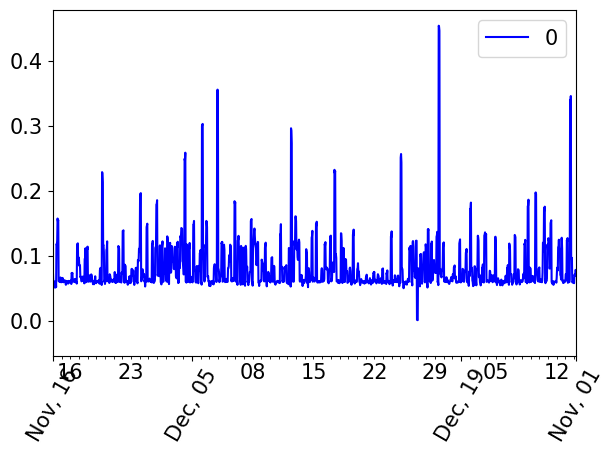

Anomalies detected: 0


In [8]:


# Check the first entry
print(f"First forecast: {forecasts[0] if len(forecasts) > 0 else 'No forecast data'}")
print(f"First time series: {tss[0] if len(tss) > 0 else 'No time series data'}")

# Plotting
plt.figure(figsize=(10, 7))
date_formatter = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in enumerate(zip(forecasts, tss)):
    print(f"Plotting index {idx}...")

    if not hasattr(forecast, 'mean') or len(forecast.mean) == 0:
        print(f"Skipping index {idx} due to empty forecast.")
        continue

    if len(ts) == 0:
        print(f"Skipping index {idx} due to empty time series.")
        continue

    print(f"Forecast mean length: {len(forecast.mean)}")
    print(f"Time series length: {len(ts)}")

    ts.plot(label="Actual", color='blue')
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.gca().xaxis.set_major_formatter(date_formatter)
    plt.title(forecast.item_id if hasattr(forecast, 'item_id') else f"Item {idx}")  # Ensure forecast.item_id exists and is accessible
    plt.legend()
    plt.tight_layout()
    plt.show()
    break  # Only show the first valid plot

# Ensure dataset_test is sliced correctly for actuals and predictions
actuals = dataset_test['Bearing 1'].values  # Adjust column name as necessary
predictions_concat = np.concatenate([f.mean for f in forecasts])
predictions = np.repeat(predictions_concat, prediction_length)[:len(actuals)]

# Calculate anomalies based on threshold
threshold = 0.5  # Adjust as needed
anomalies = np.abs(actuals - predictions) > threshold

# Ensure anomalies align with the length of dataset_test index
anomalies = np.concatenate([anomalies, np.zeros(len(dataset_test) - len(anomalies), dtype=bool)])

# Save anomaly results
anomaly_df = pd.DataFrame(index=dataset_test.index)
anomaly_df['Actual'] = actuals
anomaly_df['Predicted'] = predictions
anomaly_df['Anomaly'] = anomalies

anomaly_df.to_csv('LagLlama_Anomalies.csv')

print("Anomalies detected:", anomalies.sum())
